In [2]:
import gym
import numpy as np

In [8]:
gym.envs.register(
     id='PendulumDAE-v1',
     entry_point='pendulum.envs:PendulumDAEEnv',
     max_episode_steps=150
)
env = gym.make('PendulumDAE-v1')
#import pendulum
#env = gym.make('PendulumDAE-v0')

In [9]:
env.reset()

array([-0.8263105 , -0.56321484,  0.15005665], dtype=float32)

In [10]:
env.step(np.array([0]))

(array([-0.8280343 , -0.56067747, -0.27245143], dtype=float32),
 -6.4707354997473745,
 False,
 {})

In [11]:
env.step(np.array([0]))

(array([-0.84517604, -0.5344881 , -0.7671252 ], dtype=float32),
 -6.4915193647552965,
 False,
 {})

In [12]:
import gym
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax


# the name of this script
name = 'td3'

# the Pendulum MDP
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape), w_init=jnp.zeros),
        hk.Reshape(env.action_space.shape),
    ))
    mu = seq(S)
    return {'mu': mu, 'logvar': jnp.full_like(mu, jnp.log(0.05))}  # (almost) deterministic


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)


# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)


# target network
q1_targ = q1.copy()
q2_targ = q2.copy()
pi_targ = pi.copy()


# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)


# updaters
qlearning1 = coax.td_learning.ClippedDoubleQLearning(
    q1, pi_targ_list=[pi_targ], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3))
qlearning2 = coax.td_learning.ClippedDoubleQLearning(
    q2, pi_targ_list=[pi_targ], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3))
determ_pg = coax.policy_objectives.DeterministicPG(pi, q1_targ, optimizer=optax.adam(1e-3))


# action noise
noise = coax.utils.OrnsteinUhlenbeckNoise(mu=0., sigma=0.2, theta=0.15)


# train
while env.T < 1000000:
    s = env.reset()
    noise.reset()
    noise.sigma *= 0.99  # slowly decrease noise scale

    for t in range(env.spec.max_episode_steps):
        a = noise(pi.mode(s))
        s_next, r, done, info = env.step(a)

        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {'OrnsteinUhlenbeckNoise/sigma': noise.sigma}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 7500 and env.T % 4 == 0:
                metrics.update(determ_pg.update(transition_batch))

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
            pi_targ.soft_update(pi, tau=0.001)

        if done:
            break

        s = s_next


[td3|TrainMonitor|INFO] ep: 1,	T: 151,	G: -838,	avg_r: -5.58,	avg_G: -838,	t: 150,	dt: 12.163ms
[td3|TrainMonitor|INFO] ep: 2,	T: 302,	G: -957,	avg_r: -6.38,	avg_G: -897,	t: 150,	dt: 8.223ms
[td3|TrainMonitor|INFO] ep: 3,	T: 453,	G: -768,	avg_r: -5.12,	avg_G: -854,	t: 150,	dt: 7.683ms
[td3|TrainMonitor|INFO] ep: 4,	T: 604,	G: -1.11e+03,	avg_r: -7.42,	avg_G: -919,	t: 150,	dt: 6.696ms
[td3|TrainMonitor|INFO] ep: 5,	T: 755,	G: -723,	avg_r: -4.82,	avg_G: -880,	t: 150,	dt: 11.576ms
[td3|TrainMonitor|INFO] ep: 6,	T: 906,	G: -1.23e+03,	avg_r: -8.23,	avg_G: -939,	t: 150,	dt: 6.960ms
[td3|TrainMonitor|INFO] ep: 7,	T: 1,057,	G: -955,	avg_r: -6.36,	avg_G: -941,	t: 150,	dt: 5.940ms
[td3|TrainMonitor|INFO] ep: 8,	T: 1,208,	G: -710,	avg_r: -4.73,	avg_G: -912,	t: 150,	dt: 6.087ms
[td3|TrainMonitor|INFO] ep: 9,	T: 1,359,	G: -764,	avg_r: -5.09,	avg_G: -896,	t: 150,	dt: 6.426ms
[td3|TrainMonitor|INFO] ep: 10,	T: 1,510,	G: -849,	avg_r: -5.66,	avg_G: -891,	t: 150,	dt: 4.841ms
[td3|TrainMonitor|INFO] ep: 1

KeyboardInterrupt: 

In [ ]:
env.close()

In [13]:
s = env.reset()
s_list = []
a_list = []
for t in range(env.spec.max_episode_steps):
    a = pi(s)
    s_next, r, done, info = env.step(a)
    s_list += [s_next]
    s = s_next
   # print(s_next)
    
    a_list += [a]


[td3|TrainMonitor|INFO] ep: 25,	T: 3,670,	G: -239,	avg_r: -5.31,	avg_G: -930,	t: 45,	dt: 250.772ms


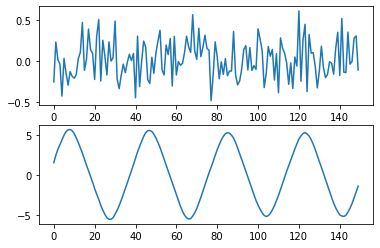

In [14]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2)
axes[0].plot([item[0] for item in  a_list])
axes[1].plot([item[2] for item in  s_list])